<h1 style="text-align:center"> 
    <font size="15"> 
        <b>AutoTrader Car Sales Prediction</b>
    </font>
</h1>

# Import Neccessary Libraries

In [1]:
# !pip install -q --upgrade scipy
# !pip install -q -U ppscore
# !pip install -q phik
# !pip install -q category_encoders
#!pip install -q catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
import phik
import ppscore

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from catboost import CatBoostRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, RFECV 
from category_encoders import TargetEncoder

from sklearn.metrics import r2_score, mean_squared_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)

import warnings 
warnings.filterwarnings("ignore")

# %config InlineBackend.figure_formats = set(('retina', 'svg'))
# plt.figure(figsize=(9,6))
# %matplotlib inline

# Data Wrangling

In [3]:
def wrangle(data):
    df = pd.read_csv(data)
    
    # set public reference as index
    df = df.set_index(df['public_reference']).drop(columns='public_reference')
    
    # Drop duplicate values and keep last value
    df.drop_duplicates(keep='last',inplace=True)
    
    ### Dealing with missing values
    
    age_identifier_df = pd.read_csv('Age_identifier_codes.csv')
    # Split the year column to get the years before the "/" and assign it back to the year column
    age_identifier_df['Year'] = age_identifier_df['Year'].str.split('/',expand=True)[0]
    year_identifier_df = pd.read_csv('Year_identifier_codes.csv')
    year_identifier_df['Year'] = year_identifier_df['Dates of issue'].str.split(' ', expand=True)[2]
    year_identifier_df['Year'][0] = 1963
    
    # Replace the wrongly imputed years with the correct ones
    df['year_of_registration'].replace([1006.0, 1007.0, 1008.0, 1009.0, 1010.0, 1015.0, 1016.0, 1017.0, 1018.0],
                                            [2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2015.0, 2016.0, 2017.0, 2018.0], inplace=True)
    # replace year 1909 with 2009
    df.loc[df['year_of_registration']==1909, 'year_of_registration'] = 2009
    df.loc[df['year_of_registration']==1515, 'year_of_registration'] = 2015
    df.loc[df['year_of_registration']==1063.0, 'year_of_registration'] = 2013
    
    # subsetting missing values in year_of_registration columns.
    missing_year_of_reg = df.query("year_of_registration.isnull()")
    missing_year_of_reg.loc[missing_year_of_reg['vehicle_condition']=="NEW", "year_of_registration"] = 2020
    missing_year_of_reg.loc[missing_year_of_reg['vehicle_condition']=="NEW", "reg_code"] = 20
    
    # This code ouputs where year_of_registration is missing but reg_code is not
    reg_code_not_missing = missing_year_of_reg[missing_year_of_reg['year_of_registration'].isnull() & ~(missing_year_of_reg['reg_code'].isnull())]
    # so as to retain the original index
    reg_code_not_missing['original_index'] = reg_code_not_missing.index
        # set reg_code as index for easy mapping
    reg_code_not_missing.set_index('reg_code',inplace=True)
        # convert the codes  columns in the age_identifier dataframe to list and add the lists together 
    agelist1 = age_identifier_df['1 March – 31 August'].values.tolist()
    agelist2 = age_identifier_df['1 September – 28/29 February'].astype(str).values.tolist()
    agelist = agelist1 + agelist2
    # add year to itself
    year = age_identifier_df['Year'].values.tolist() + age_identifier_df['Year'].values.tolist()
    modified_age_identifier = pd.DataFrame(dict(year=year,code=agelist))
    # filling for only age identifier
    reg_code_not_missing['year_of_registration'] = reg_code_not_missing.index.map(modified_age_identifier.set_index('code')['year'])
    # resetting the index back  to the original index so i can merge with my intial data 
    reg_code_not_missing = reg_code_not_missing.reset_index().set_index('original_index')
    
    # create dictionaries from the year identifier dataframe to fill the missing years of registration with Letter reg_codes
    year_dict = dict(zip(year_identifier_df['Letter'],year_identifier_df['Year']))
    reg_code_not_missing['year_of_registration'] = reg_code_not_missing['year_of_registration'].fillna(reg_code_not_missing['reg_code'].astype(str).map(year_dict))
    
    # replacing the missing value in year of registration
    (missing_year_of_reg.loc[missing_year_of_reg['year_of_registration']
                             .isnull() & ~(missing_year_of_reg['reg_code'].isnull()),'year_of_registration']
    ) = reg_code_not_missing['year_of_registration']
    mode_used_cars = missing_year_of_reg.groupby('vehicle_condition')['year_of_registration'].apply(pd.Series.mode)[1]
    missing_year_of_reg.loc[missing_year_of_reg['year_of_registration'].isnull() & (missing_year_of_reg['reg_code'].isnull()),'year_of_registration'] = int(mode_used_cars)
    missing_year_of_reg.loc[(missing_year_of_reg['reg_code'].isnull()),'reg_code'] = 17
    
    # Apply all changes to the main dataframe 
    df.loc[df['vehicle_condition']=="NEW", "year_of_registration"] = 2020
    df.loc[df['vehicle_condition']=="NEW", "reg_code"] = 20
    
    # fill missing values
    (df.loc[(df['year_of_registration']
                 .isnull()) & 
                 ~(df['reg_code'].isnull()), 'year_of_registration'] 
    )= missing_year_of_reg['year_of_registration']
    
    # fill missng values with the year of registration mode of used cars
    df.loc[df['year_of_registration'].isnull() & (df['reg_code'].isnull()),'year_of_registration'] = int(mode_used_cars)
    df.loc[df['reg_code'].isnull(),'reg_code'] = 17
    
    # Drop the two remaining missing observations in the year_of_registration column
    (df
     .drop(df[df['year_of_registration'].isnull()].index,
          inplace=True)
    )
    # change year_of_registration dataype to Integer
    df['year_of_registration'] = df['year_of_registration'].astype('int64')

    ### Dealing with years greater than 2020
    irregular = df[df['year_of_registration']> 2020][['standard_make','standard_model']]
    results = []
    for i, j in irregular.iterrows():
        result = df[(df['standard_make']==j['standard_make']) & (df['standard_model']==j['standard_model'])]\
        ['year_of_registration'].value_counts().sort_values(ascending=False).index[0]
        results.append(result)
    irregular['new_year_of_registration'] = results
    df.loc[df['year_of_registration']> 2020, 'year_of_registration'] = irregular['new_year_of_registration']
    df.loc[(df['year_of_registration']< 1900)&(df['year_of_registration']!=0), 'year_of_registration'] = 2013
    
    #### Creating a function to fill missing categorical values with the mode
    def fillna_with_mode(missing_col):
        df[missing_col] = df.groupby(['standard_make', 'standard_model'])[missing_col].apply(lambda x: x.fillna(scipy.stats.mode(x)[0][0]))
        return df
    # fill null values in fuel_type and assigning the resulting dataframe to a variable
    df = fillna_with_mode('fuel_type')
    # Creating another function to handle the above situation. By grouping the make and model of each car,
    # perform a value counts on the missing column and sort the counts in descending order. Then take the first index
    
    def refillna_with_mode(missing_col):
        missing_values = df[df[missing_col].isnull()]
        brand_model = missing_values[['standard_make','standard_model']]

        results = []
        for i, j in brand_model.iterrows():
            try:
                result = (df[(df['standard_make']==j['standard_make']) & (df['standard_model']==j['standard_model'])][missing_col]
                .value_counts().sort_values(ascending=False).index[0])
                results.append(result)
            except IndexError:
                results.append("no value")
        brand_model[missing_col] = results
        return brand_model

    # refilling the missing values with the mode of each category
    filled_fuel_type = refillna_with_mode('fuel_type')
    # fill the missing values
    df.loc[df['fuel_type'].isnull(), "fuel_type"] = filled_fuel_type['fuel_type']
    (df['fuel_type']
             .replace("no value", df['fuel_type'].value_counts().sort_values(ascending=False).index[0],
              inplace=True)
    )
    
    # mileage
    missing_mileage = df[df['mileage'].isnull()]
    missing_mileage['mileage'] = df.query("vehicle_condition=='USED'").groupby(['year_of_registration','fuel_type'])['mileage'].apply(lambda x : x.fillna(round(x.median(),1)))
    df.loc[df['mileage'].isnull(), 'mileage'] = missing_mileage['mileage']
    
    # colour
    df = fillna_with_mode('standard_colour')
    # refilling the missing values with the mode of each category
    filled_fuel_type = refillna_with_mode('standard_colour')
    df.loc[df['standard_colour'].isnull(), "standard_colour"] = filled_fuel_type['standard_colour']
    (df['standard_colour']
             .replace("no value", df['standard_colour'].mode()[0],
              inplace=True)
    )
    
    # body type
    df = fillna_with_mode('body_type')
    filled_body_type = refillna_with_mode('body_type')
    df.loc[df['body_type'].isnull(), "body_type"] = filled_body_type['body_type']

    # Volkswagen Caddy is the most occuring brand & model. Using google to look up the car's body
    df.loc[(df['standard_make']=='Volkswagen') & (df['standard_model']=='Caddy'), 'body_type'] = 'MPV'
    df = df[~(df['body_type']=='no value')]
    return df

### Load the data

In [4]:
adverts = wrangle("adverts.csv")
adverts.head()

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
public_reference,,,,,,,,,,,
202006039777689,0.0,20,Grey,Volvo,XC90,NEW,2020,73970,SUV,False,Petrol Plug-in Hybrid
202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011,7000,Saloon,False,Diesel
202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017,14000,SUV,False,Petrol
202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016,7995,Hatchback,False,Diesel
202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015,26995,SUV,False,Diesel


In [5]:
adverts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393353 entries, 202006039777689 to 201512149444029
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   mileage                393353 non-null  float64
 1   reg_code               393353 non-null  object 
 2   standard_colour        393353 non-null  object 
 3   standard_make          393353 non-null  object 
 4   standard_model         393353 non-null  object 
 5   vehicle_condition      393353 non-null  object 
 6   year_of_registration   393353 non-null  int64  
 7   price                  393353 non-null  int64  
 8   body_type              393353 non-null  object 
 9   crossover_car_and_van  393353 non-null  bool   
 10  fuel_type              393353 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 33.4+ MB


In [6]:
adverts.isnull().sum()

mileage                  0
reg_code                 0
standard_colour          0
standard_make            0
standard_model           0
vehicle_condition        0
year_of_registration     0
price                    0
body_type                0
crossover_car_and_van    0
fuel_type                0
dtype: int64

# Identifying Outliers and Handling Outliers

<font size="4">I will be identifying outliers by visualizing the data points using `seaborn.boxplot()`. 
   

#### `Mileage`

In [7]:
adverts['mileage'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
mileage,393353.0,38514.423557,34757.432277,0.0,11510.0,29435.0,57633.0,999999.0


<font size="4">The maximum mileage is 999,999km/h which is outrageous. Plotting a boxplot to visualize how the data points are distributed

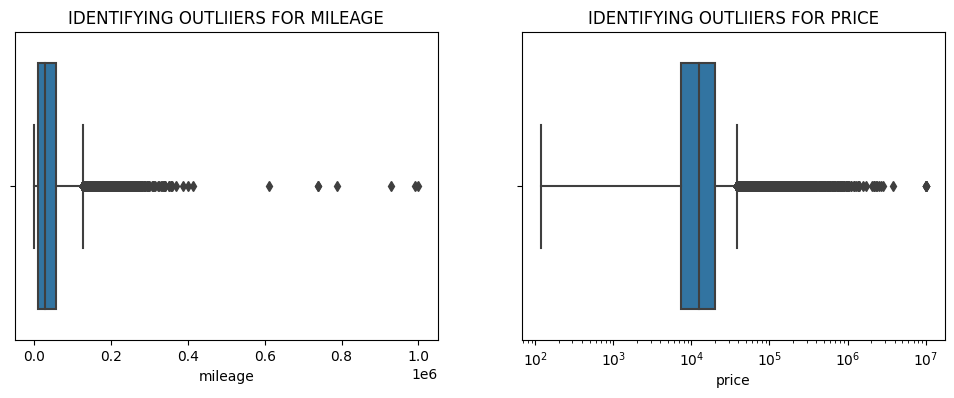

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

sns.boxplot(x=adverts['mileage'],ax=ax[0])
ax[0].title.set_text('Identifying Outliiers for Mileage'.upper())

sns.boxplot(x=adverts['price'],ax=ax[1])
ax[1].title.set_text('Identifying Outliiers for price'.upper())
ax[1].set_xscale('log')

In [9]:
adverts[['standard_make','standard_model','year_of_registration','mileage', 'price']].sort_values(by='mileage', ascending=False)[:10]

,standard_make,standard_model,year_of_registration,mileage,price
public_reference,,,,,
202008122406434,Vauxhall,Astra,2013,999999.0,9999
202010235350884,Vauxhall,Zafira,2007,990000.0,1200
202010285542410,BMW,1 Series,2006,930000.0,2500
202010064664710,MINI,Countryman,2018,788072.0,22875
202009244163289,Mercedes-Benz,E Class,2011,740000.0,10500
202010215262290,Volvo,XC90,2014,740000.0,14795
202010225297076,Fiat,500,2013,611121.0,4500
202007301907676,SKODA,Octavia,2010,413079.0,1299
202009033271274,BMW,X5,2016,400321.0,28690


<font size="4">In general, most modern cars can cross 200,000 miles without any major issues, provided the vehicle is being well-maintained but it is no surprise that many vehicles that have reached 400,000 and even 500,000 miles have received extraordinary care and maintenance, often with the owners doing the routine work themselves.</font>

<font size="4">From the boxplot above, and the subset of the data, I can cap outliers for mileage at values greater than 200,000km/h

In [10]:
#observations gretaer than 400k km/h
adverts.loc[adverts['mileage']>200000].count().values[0]

340

<font size="4"> Handling Outlier in `mileage` column

In [11]:
adverts.loc[adverts['mileage']>200000, 'mileage'] = 200000

### `Price`

In [12]:
adverts['price'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
price,393353.0,17168.541712,46694.89296,120.0,7450.0,12495.0,19990.0,9999999.0


<font size="4">The maximum price of a car is £9,999,999. Plotting a boxplot to visualize how the data points are distributed

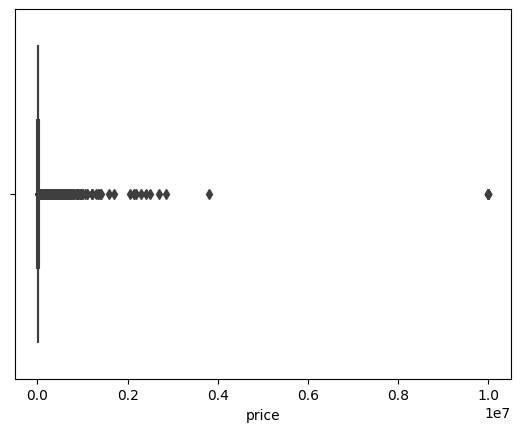

In [13]:
sns.boxplot(x=adverts['price']);

<font size="4">Treating the outliers in `price` by `vehicle_condition`. i.e a subset of each vehicle condition is created and outliers are checked and handled individually.

In [14]:
# for used cars
used_cars = adverts.query("vehicle_condition=='USED'")
used_cars['price'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
price,368866.0,16012.375996,47713.274997,120.0,6999.0,11800.0,18500.0,9999999.0


In [15]:
used_cars['price'].quantile(0.93)

32995.0

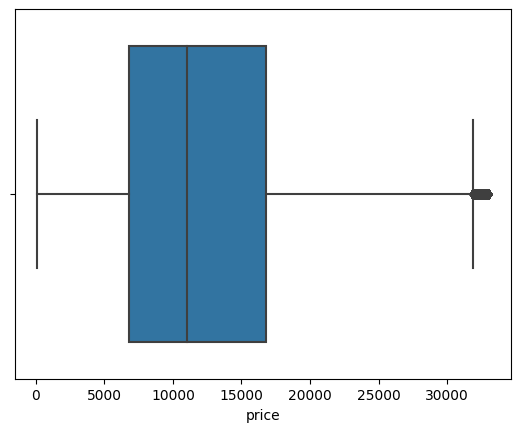

In [16]:
sns.boxplot(x=used_cars.loc[used_cars['price']<=used_cars['price'].quantile(0.93)]['price']);

In [17]:
used_cars['price'].median()

11800.0

In [18]:
used_cars = used_cars.loc[used_cars['price']<used_cars['price'].quantile(0.93)]

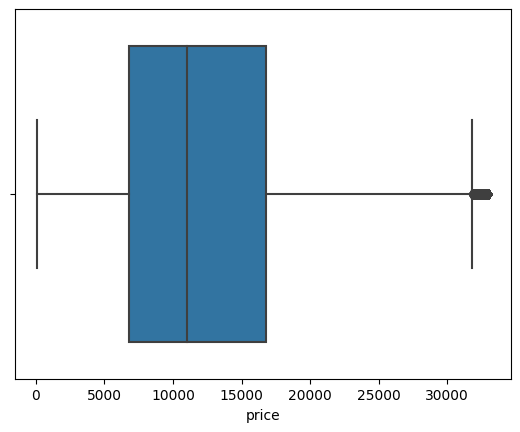

In [19]:
sns.boxplot(x=used_cars['price']);

In [20]:
# for new cars
new_cars = adverts.query("vehicle_condition=='NEW'")
new_cars['price'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
price,24487.0,34584.730837,20216.114699,7815.0,20700.0,28040.0,42042.5,293635.0


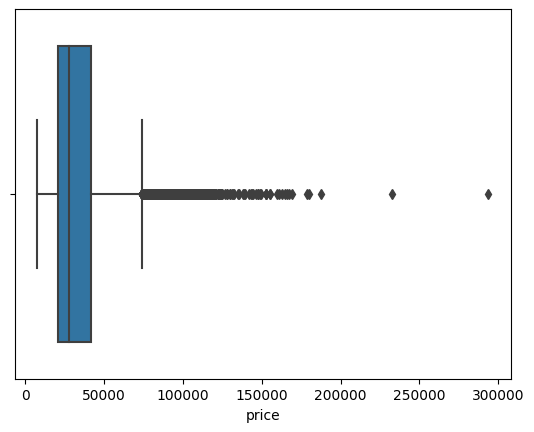

In [21]:
sns.boxplot(x=new_cars['price']);

In [22]:
new_cars['price'].quantile(0.92)

68465.6

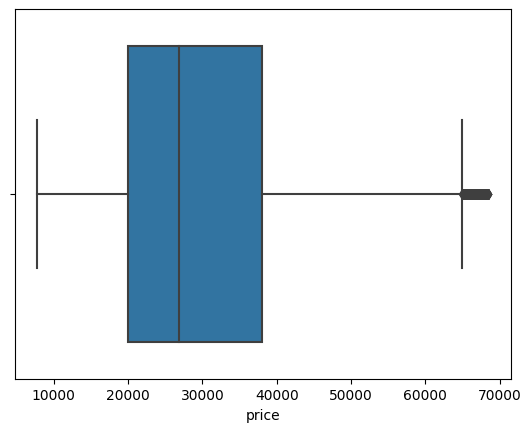

In [23]:
sns.boxplot(x=new_cars.loc[new_cars['price']<=new_cars['price'].quantile(0.92)]['price']);

In [24]:
new_cars = new_cars.loc[new_cars['price']<=new_cars['price'].quantile(0.92)]

In [25]:
# new_cars.loc[new_cars['price']>new_cars['price'].quantile(0.99),'price'] = new_cars['price'].quantile(0.99)

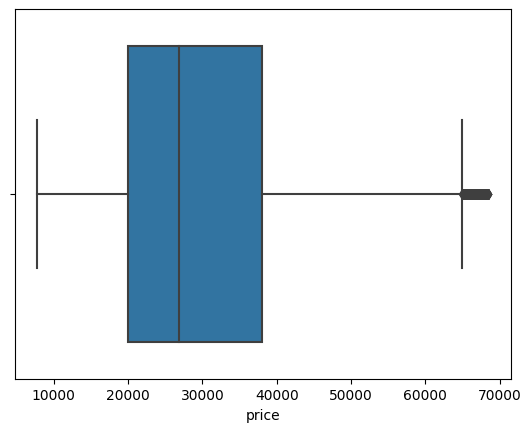

In [26]:
sns.boxplot(x=new_cars['price']);

In [27]:
adverts = pd.concat([new_cars,used_cars])

# Feature Engineering

In [28]:
adverts.head(2)

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
public_reference,,,,,,,,,,,
201911043995897,5.0,20,Black,Nissan,X-Trail,NEW,2020,27595,SUV,False,Diesel
202008272998331,0.0,20,White,Volkswagen,T-Cross,NEW,2020,25000,SUV,False,Petrol


#### Create a new column `vehicle_age`

<font size='4'>Creating a new column for age of cars as at when the advert was posted on the website. A critical look at the `public_reference` column shows the year, month, day and some ID of each adverts. </font>
1. <font size='4'> I will grab the first 4 digits from the public reference column,
2. <font size='4'> Assign to a new column titled (advert_year) 
3. <font size='4'> Subtract the `year_of_registration` from the `advert_year`
4. <font size='4'> Assign the result of step 3 to`vehicle_age`

In [29]:
adverts['advert_year'] = adverts.index.astype(str).str[:4].astype('int64')

In [30]:
adverts['vehicle_age'] = adverts['advert_year'] - adverts['year_of_registration']

In [31]:
adverts.head(2)

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,advert_year,vehicle_age
public_reference,,,,,,,,,,,,,
201911043995897,5.0,20,Black,Nissan,X-Trail,NEW,2020,27595,SUV,False,Diesel,2019,-1
202008272998331,0.0,20,White,Volkswagen,T-Cross,NEW,2020,25000,SUV,False,Petrol,2020,0


In [32]:
adverts['vehicle_age'].unique()

array([-1,  0, -2,  9,  3,  4,  5,  7, 12, 10,  1,  8,  2, 11,  6, 17, 14,
       15, 20, 18, 13, 16, 29, 19, 34, 22, 27, 33, 26, 21, 28, 25, 23, 51,
       30, 36, 32, 31, 24, 40, 53, 48, 50, 41, 87, 39, 35, 49, 47, 46, 54,
       38, 43, 37, 52, 55, 44, 42, 63, 45, 56, 65, 58, 57, 86, 62, 59, 64,
       60, 61, 68, 66], dtype=int64)

In [33]:
adverts[adverts['vehicle_age']<0].groupby('vehicle_condition')[['advert_year','year_of_registration','vehicle_age']].value_counts()

vehicle_condition  advert_year  year_of_registration  vehicle_age
NEW                2019         2020                  -1             1036
                   2018         2020                  -2               27
USED               2019         2020                  -1              186
                   2018         2019                  -1                4
                                2020                  -2                3
                   2017         2018                  -1                2
dtype: int64

In [34]:
# replace -1 to 0 for observation that have advert year=2019, year of registration=2020, vehicle age=-1, and are also used cars
# for Used cars
(adverts.loc[(adverts['advert_year']==2019) 
         & (adverts['year_of_registration']==2020) 
         & (adverts['vehicle_condition']=='USED')
         & (adverts['vehicle_age']==-1),
         'vehicle_age']
) = 0

# for new cars
(adverts.loc[(adverts['advert_year']==2019) 
         & (adverts['year_of_registration']==2020) 
         & (adverts['vehicle_condition']=='NEW')
         & (adverts['vehicle_age']==-1),
         'vehicle_age']
) = 0

(adverts.loc[(adverts['advert_year']==2018) 
         & (adverts['year_of_registration']==2020) 
         & (adverts['vehicle_condition']=='NEW')
         & (adverts['vehicle_age']==-2),
         'vehicle_age']
) = 0

In [35]:
adverts[adverts['vehicle_age']<0].groupby('vehicle_condition')[['advert_year','year_of_registration','vehicle_age']].value_counts()

vehicle_condition  advert_year  year_of_registration  vehicle_age
USED               2018         2019                  -1             4
                                2020                  -2             3
                   2017         2018                  -1             2
dtype: int64

<font size="4">Taking the absolute values of the remaining negavtive values in `vehicle_age` column

In [36]:
adverts.loc[adverts['vehicle_age']<0, 'vehicle_age'] = abs(adverts[adverts['vehicle_age']<0]['vehicle_age'])

In [37]:
adverts[adverts['vehicle_age']<0]

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,advert_year,vehicle_age
public_reference,,,,,,,,,,,,,


#### Create a column for average miles travelled by a car each year 

<font size="4"> That's dividing the `mileage` by the `vehicle_age`

In [38]:
adverts['avg_miles_per_year'] = adverts['mileage'] / adverts['vehicle_age']

In [39]:
adverts['avg_miles_per_year'].isnull().sum()

10395

<font size="4">There are over 10,395 missing values in the newly created column. This is because we have **0** dividing **0** from the `mileage` and `vehicle_age` division

In [40]:
adverts[adverts['avg_miles_per_year'].isnull()].head()

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,advert_year,vehicle_age,avg_miles_per_year
public_reference,,,,,,,,,,,,,,
202008272998331,0.0,20,White,Volkswagen,T-Cross,NEW,2020,25000,SUV,False,Petrol,2020,0,NaN
202003178531910,0.0,20,Silver,Honda,Civic,NEW,2020,19495,Hatchback,False,Petrol,2020,0,NaN
202010144973622,0.0,20,Silver,Audi,Q3,NEW,2020,41101,SUV,False,Diesel,2020,0,NaN
202010285552400,0.0,20,Grey,Volvo,XC90,NEW,2020,63346,SUV,False,Diesel Hybrid,2020,0,NaN
201909132192901,0.0,20,Blue,Vauxhall,Astra,NEW,2020,18894,Hatchback,False,Petrol,2019,0,NaN


In [41]:
# fill those missing values with zeros
adverts['avg_miles_per_year'].fillna(0,inplace=True)

In [42]:
adverts[adverts['avg_miles_per_year']<0].head()

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,advert_year,vehicle_age,avg_miles_per_year
public_reference,,,,,,,,,,,,,,


In [43]:
adverts['avg_miles_per_year'].value_counts()

inf             33553
0.000000e+00    10430
1.000000e+04     2185
8.000000e+03     1819
7.000000e+03     1783
                ...  
1.034143e+04        1
1.164680e+04        1
1.832267e+04        1
3.566222e+03        1
6.793818e+03        1
Name: avg_miles_per_year, Length: 111219, dtype: int64

<font size="4">In situations where `vehicle_age` is **0** and `mileage` is greater than 0, pandas returns an (infinite ***(inf)***) value when you have a number that's not divisible by 0

In [44]:
adverts[adverts['avg_miles_per_year']==np.inf].head()

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,advert_year,vehicle_age,avg_miles_per_year
public_reference,,,,,,,,,,,,,,
201911043995897,5.0,20,Black,Nissan,X-Trail,NEW,2020,27595,SUV,False,Diesel,2019,0,inf
202007161315831,10.0,20,White,BMW,3 Series,NEW,2020,38905,Estate,False,Diesel,2020,0,inf
202009143697500,4.0,20,Black,Volkswagen,Golf,NEW,2020,26292,Hatchback,False,Petrol,2020,0,inf
202009304409714,10.0,20,White,Mitsubishi,Mirage,NEW,2020,14615,Hatchback,False,Petrol,2020,0,inf
202010054632179,1.0,20,White,BMW,X3,NEW,2020,41980,SUV,False,Diesel Hybrid,2020,0,inf


<font size="4">Replacing the infinite ***(inf)*** values with the mileage value of that particular index

In [45]:
adverts.loc[adverts['avg_miles_per_year']==np.inf, 'avg_miles_per_year'] = adverts[adverts['avg_miles_per_year']==np.inf]['mileage']

In [46]:
adverts['avg_miles_per_year'].value_counts()

0.000000        10430
10.000000        9341
10000.000000     2210
5.000000         2120
5000.000000      2014
                ...  
9931.100000         1
11387.500000        1
6571.714286         1
10732.666667        1
6793.818182         1
Name: avg_miles_per_year, Length: 111961, dtype: int64

In [47]:
adverts['avg_miles_per_year'] = adverts['avg_miles_per_year'].astype('int64')

In [48]:
adverts.dtypes

mileage                  float64
reg_code                  object
standard_colour           object
standard_make             object
standard_model            object
vehicle_condition         object
year_of_registration       int64
price                      int64
body_type                 object
crossover_car_and_van       bool
fuel_type                 object
advert_year                int64
vehicle_age                int64
avg_miles_per_year         int64
dtype: object

# Data Transformation

In [49]:
categorical_feat = [col for col in adverts.columns if adverts[col].dtype=='O']
num_feat = [col for col in adverts.columns if col not in categorical_feat][1:]

In [50]:
adverts.dtypes

mileage                  float64
reg_code                  object
standard_colour           object
standard_make             object
standard_model            object
vehicle_condition         object
year_of_registration       int64
price                      int64
body_type                 object
crossover_car_and_van       bool
fuel_type                 object
advert_year                int64
vehicle_age                int64
avg_miles_per_year         int64
dtype: object

In [51]:
adverts['mileage'] = adverts['mileage'].astype('int64')
adverts['crossover_car_and_van'] = adverts['crossover_car_and_van'].astype('category').cat.codes.astype('int64')

In [52]:
adverts.head(2)

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,advert_year,vehicle_age,avg_miles_per_year
public_reference,,,,,,,,,,,,,,
201911043995897,5,20,Black,Nissan,X-Trail,NEW,2020,27595,SUV,0,Diesel,2019,0,5
202008272998331,0,20,White,Volkswagen,T-Cross,NEW,2020,25000,SUV,0,Petrol,2020,0,0


In [53]:
# transforming all object values to upper case
adverts[categorical_feat] = adverts[categorical_feat].apply(lambda x: x.astype(str).str.upper())

In [54]:
# remove spaces inbetween words to form a uniform name 
adverts[categorical_feat] = adverts[categorical_feat].apply(lambda x: x.astype(str).str.replace(' ',''))

In [55]:
adverts[categorical_feat]['standard_model'].nunique()

992

In [56]:
adverts.loc[adverts['fuel_type']=='NATURALGAS', 'fuel_type'] = 'BIFUEL'

#### Sampling

In [57]:
adverts_sample = adverts.sample(frac=0.10, random_state=1234)
adverts_sample.shape

(36537, 14)

In [58]:
adverts_sample['standard_colour'].value_counts()

BLACK          7927
WHITE          6631
GREY           5982
BLUE           5471
SILVER         4641
RED            4039
GREEN           419
ORANGE          360
BROWN           214
BEIGE           160
YELLOW          152
BRONZE          138
MULTICOLOUR     136
PURPLE          106
GOLD             73
TURQUOISE        36
PINK             26
MAROON           18
BURGUNDY          6
NAVY              1
MAGENTA           1
Name: standard_colour, dtype: int64

## Still on feature engineering

Trying to reduce the number of categories in some columns.

In [59]:
def check_num_unique_cats(col_lst):
    for i in range(len(col_lst)):
        result = adverts[col_lst[i]].nunique()
        print(col_lst[i])
        print(result)
check_num_unique_cats(adverts_sample.columns)

mileage
79860
reg_code
66
standard_colour
22
standard_make
93
standard_model
992
vehicle_condition
2
year_of_registration
70
price
25145
body_type
16
crossover_car_and_van
2
fuel_type
8
advert_year
8
vehicle_age
70
avg_miles_per_year
25424


In [60]:
def reduce_categories(x, col, threshold):
    """
    A function to reduce categories in a column by taking a reasonable threshold
    """
    x = pd.DataFrame(adverts_sample[col].value_counts() > threshold)
    others = x[x[col]==False].index.tolist()
    adverts_sample.loc[adverts_sample[col].isin(others), col] = 'OTHER_' + col.upper()
    return adverts_sample

In [61]:
adverts_sample['standard_colour'].value_counts()

BLACK          7927
WHITE          6631
GREY           5982
BLUE           5471
SILVER         4641
RED            4039
GREEN           419
ORANGE          360
BROWN           214
BEIGE           160
YELLOW          152
BRONZE          138
MULTICOLOUR     136
PURPLE          106
GOLD             73
TURQUOISE        36
PINK             26
MAROON           18
BURGUNDY          6
NAVY              1
MAGENTA           1
Name: standard_colour, dtype: int64

In [62]:
# For Colour 
adverts_sample = reduce_categories(adverts_sample, 'standard_colour', 100)

In [63]:
adverts_sample['standard_colour'].value_counts()

BLACK                    7927
WHITE                    6631
GREY                     5982
BLUE                     5471
SILVER                   4641
RED                      4039
GREEN                     419
ORANGE                    360
BROWN                     214
OTHER_STANDARD_COLOUR     161
BEIGE                     160
YELLOW                    152
BRONZE                    138
MULTICOLOUR               136
PURPLE                    106
Name: standard_colour, dtype: int64

#### For Standard Make
It doesn't make good sense doing the same thing for `standard_make` and `standard_model` seperately. The best thing to do is to merge both `standard_make` and `standard_model` into a column so we are dealing with the car as a whole. 

In [64]:
# adverts_sample['Car'] = adverts_sample['standard_make'] + '_' + adverts_sample['standard_model']

In [65]:
# adverts_sample.head()

In [66]:
# x = pd.DataFrame(adverts_sample['Car'].value_counts() == 1)

In [67]:
# x.query("Car==True").index

In [68]:
# adverts_sample[adverts_sample['Car'].isin(x.query("Car==True").index.tolist())]

#### For Body Type

In [69]:
adverts_sample['body_type'].value_counts()

HATCHBACK        16278
SUV               9747
SALOON            3341
ESTATE            2355
COUPE             1789
MPV               1539
CONVERTIBLE       1346
PICKUP              63
COMBIVAN            31
MINIBUS             22
LIMOUSINE            8
PANELVAN             6
WINDOWVAN            6
CAMPER               5
CARDERIVEDVAN        1
Name: body_type, dtype: int64

In [70]:
vans = {i for i in adverts_sample['body_type'].values if "van" in i.lower()}
vans = list(vans)
vans

['CARDERIVEDVAN', 'WINDOWVAN', 'PANELVAN', 'COMBIVAN']

In [71]:
for i in vans:
    print(i)
    print(adverts_sample[adverts_sample["body_type"]==i]['price'].mean())

CARDERIVEDVAN
10495.0
WINDOWVAN
9320.666666666666
PANELVAN
12656.5
COMBIVAN
15302.258064516129


We are going to combine all the vans together and into one category

In [72]:
adverts_sample.loc[adverts_sample['body_type'].isin(vans), 'body_type'] = "VANS"

In [73]:
adverts_sample['body_type'].value_counts()

HATCHBACK      16278
SUV             9747
SALOON          3341
ESTATE          2355
COUPE           1789
MPV             1539
CONVERTIBLE     1346
PICKUP            63
VANS              44
MINIBUS           22
LIMOUSINE          8
CAMPER             5
Name: body_type, dtype: int64

Drop `CHASSISCAB` from the dataset

In [74]:
adverts_sample = adverts_sample[~(adverts_sample["body_type"]=='CHASSISCAB')]

#### For Fuel_Type

In [75]:
adverts_sample['fuel_type'].value_counts()

PETROL                 19804
DIESEL                 14610
PETROLHYBRID            1259
PETROLPLUG-INHYBRID      430
ELECTRIC                 334
DIESELHYBRID              78
BIFUEL                    18
DIESELPLUG-INHYBRID        4
Name: fuel_type, dtype: int64

#### Feature Correlation with price using `Phik library`

In [76]:
# feat_corr = adverts_sample.phik_matrix()

In [77]:
# plt.figure(figsize=(10,10))
# sns.heatmap(feat_corr, annot=True)

In [78]:
# feat_corr['price'].drop('price').sort_values(ascending=True).plot(kind='barh')
# plt.title('feature selection'.upper(),weight='bold')
# plt.ylabel('features')
# plt.xlabel('phik coefficient')

Excluding `vehicle_age` and  `reg_code` from the column of interests because of colinearity with `year_of_registration`.

In [79]:
cols_of_interest = ['mileage','standard_colour','standard_make','standard_model',\
'vehicle_condition', 'year_of_registration','body_type','fuel_type','advert_year','avg_miles_per_year']

In [80]:
adverts_sample.sort_values(by='price', ascending=False)

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,advert_year,vehicle_age,avg_miles_per_year
public_reference,,,,,,,,,,,,,,
202010305597152,0,20,GREY,VOLVO,XC90,NEW,2020,68320,SUV,0,DIESEL,2020,0,0
202009203975483,10,20,GREY,BMW,X6,NEW,2020,68224,SUV,0,PETROL,2020,0,10
202002046912181,10,20,GREY,MERCEDES-BENZ,SLCLASS,NEW,2020,68114,CONVERTIBLE,0,PETROL,2020,0,10
202010014426227,0,20,WHITE,LANDROVER,DEFENDER110,NEW,2020,67995,SUV,0,DIESEL,2020,0,0
202003118277296,10,20,RED,AUDI,RS4AVANT,NEW,2020,67982,ESTATE,0,PETROL,2020,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202010275502623,90000,56,BLACK,PEUGEOT,206,USED,2006,295,HATCHBACK,0,PETROL,2020,14,6428
202011015664758,175967,07,BLUE,VAUXHALL,VECTRA,USED,2007,250,HATCHBACK,0,PETROL,2020,13,13535
202010275500715,99000,08,SILVER,RENAULT,MEGANE,USED,2008,250,HATCHBACK,0,PETROL,2020,12,8250


In [81]:
X = adverts_sample[cols_of_interest]
y = adverts_sample['price']

In [82]:
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

#### Performing target  encoding on `standard make` and `standard model`

In [83]:
encoder = TargetEncoder(cols=['standard_make','standard_model']).fit(X_train, y_train) 
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [84]:
X_train.head()

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,body_type,fuel_type,advert_year,avg_miles_per_year
public_reference,,,,,,,,,,
202009224063377,21241,WHITE,13000.368207,13040.923345,USED,2019,HATCHBACK,PETROL,2020,21241
202009163787354,31179,RED,7858.979495,6968.715909,USED,2018,HATCHBACK,PETROL,2020,15589
202008172579259,0,BLUE,7990.355556,6281.414665,NEW,2020,HATCHBACK,PETROL,2020,0
202010155034570,25000,RED,12938.074341,6450.865731,USED,2016,HATCHBACK,PETROL,2020,6250
202006300682302,45000,BLUE,11293.980769,15198.678698,USED,2017,SUV,DIESEL,2020,15000


### Create preprocessing Pipeline

In [85]:
def preprocessor_pipe():
    numeric_features = ['mileage','year_of_registration','avg_miles_per_year','advert_year','standard_make','standard_model']
    numeric_transformer = Pipeline(
        steps=[
            # its a good practice to do the polynomial/interaction feature generation before scaling.
            ("poly_int", PolynomialFeatures(interaction_only=True, include_bias=False)),
            ("scaler", StandardScaler())
        ]
    ).set_output(transform='pandas')

    categorical_features = ['standard_colour','vehicle_condition','body_type','fuel_type']
    categorical_transformer = Pipeline(
        steps=[
            ("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False, drop='if_binary')),
        ]
    ).set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [86]:
preprocessor = preprocessor_pipe() 
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [87]:
X_train_preprocessed

,mileage,year_of_registration,avg_miles_per_year,advert_year,standard_make,standard_model,mileage year_of_registration,mileage avg_miles_per_year,mileage advert_year,mileage standard_make,...,body_type_SUV,body_type_VANS,fuel_type_BIFUEL,fuel_type_DIESEL,fuel_type_DIESELHYBRID,fuel_type_DIESELPLUG-INHYBRID,fuel_type_ELECTRIC,fuel_type_PETROL,fuel_type_PETROLHYBRID,fuel_type_PETROLPLUG-INHYBRID
public_reference,,,,,,,,,,,,,,,,,,,,,
202009224063377,-0.558924,0.896940,2.316324,0.112678,-0.071967,-0.034724,-0.557941,0.034047,-0.558921,-0.516917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
202009163787354,-0.272967,0.664553,1.306093,0.112678,-1.450066,-1.247297,-0.270981,0.096651,-0.272961,-0.574990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
202008172579259,-1.170115,1.129327,-1.480266,0.112678,-1.414852,-1.384546,-1.172232,-0.775989,-1.170118,-1.032462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
202010155034570,-0.450762,0.199779,-0.363149,0.112678,-0.088665,-1.350708,-0.450305,-0.495462,-0.450758,-0.428589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
202006300682302,0.124721,0.432166,1.200816,0.112678,-0.529348,0.396163,0.127880,0.435887,0.124730,-0.083617,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202009274272868,1.534652,-0.264995,1.319856,0.112678,1.083112,0.707158,1.539518,1.867883,1.534676,2.005301,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
202007101091437,0.326139,-0.264995,0.068684,0.112678,2.206856,-0.310262,0.327885,0.033063,0.326151,1.055014,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
202001306758184,1.651044,-1.426930,0.112833,0.112678,-1.446827,-1.545755,1.649188,0.792942,1.651068,0.408308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Trying out Principal Component Analysis using the pre processed data set

In [88]:
X_pca = PCA()
X_pca.fit(X_train_preprocessed)

PCA()

In [89]:
X_pca.explained_variance_ratio_

array([3.89916221e-01, 2.61509554e-01, 1.42541949e-01, 4.68276148e-02,
       4.33226444e-02, 2.08739192e-02, 1.50922302e-02, 9.23133947e-03,
       8.71249673e-03, 7.49121796e-03, 6.66657250e-03, 6.61479340e-03,
       5.59909838e-03, 5.48637541e-03, 4.69629242e-03, 3.98170805e-03,
       3.28668876e-03, 2.39178255e-03, 2.18907027e-03, 1.87394493e-03,
       1.72214677e-03, 1.59080030e-03, 1.49754246e-03, 1.37239748e-03,
       1.03713647e-03, 7.12866839e-04, 6.71566205e-04, 5.17226712e-04,
       4.44099586e-04, 4.18690131e-04, 3.09240067e-04, 2.34004369e-04,
       1.97124722e-04, 1.91192961e-04, 1.70503342e-04, 1.60172206e-04,
       1.35821065e-04, 1.03399285e-04, 9.18206510e-05, 5.35285403e-05,
       2.76158567e-05, 1.81985224e-05, 1.03486113e-05, 5.06171262e-06,
       1.79479625e-06, 1.18685802e-07, 5.36683098e-08, 1.26019404e-08,
       1.08515412e-09, 3.70766738e-10, 2.06111844e-10, 1.65770427e-10,
       3.92200348e-11, 2.57658764e-11, 7.68974158e-32, 3.04260125e-33,
      

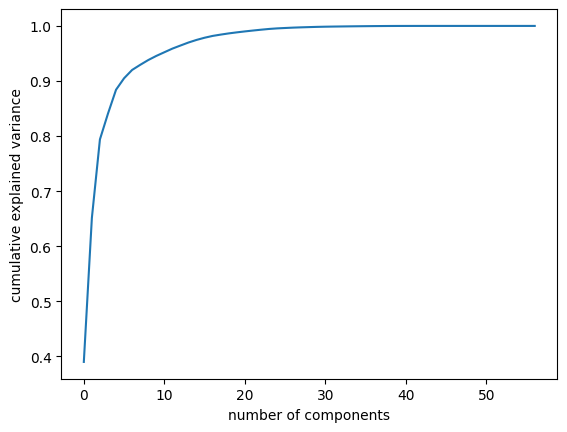

In [90]:
plt.plot(np.cumsum(X_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

 n_components=0.95. This will select the number of components while preserving 95% of the variability in the data.

In [91]:
X_pca = PCA(n_components=0.95,random_state=seed)
X_pca.fit(X_train_preprocessed)
pca_X = X_pca.transform(X_train_preprocessed)
pca_test = X_pca.transform(X_test_preprocessed)

In [92]:
pca_X.shape

(27402, 11)

In [93]:
components = []
for i in range(1,pca_X.shape[1]+1):
    components.append('component'+str(i))    

In [94]:
components

['component1',
 'component2',
 'component3',
 'component4',
 'component5',
 'component6',
 'component7',
 'component8',
 'component9',
 'component10',
 'component11']

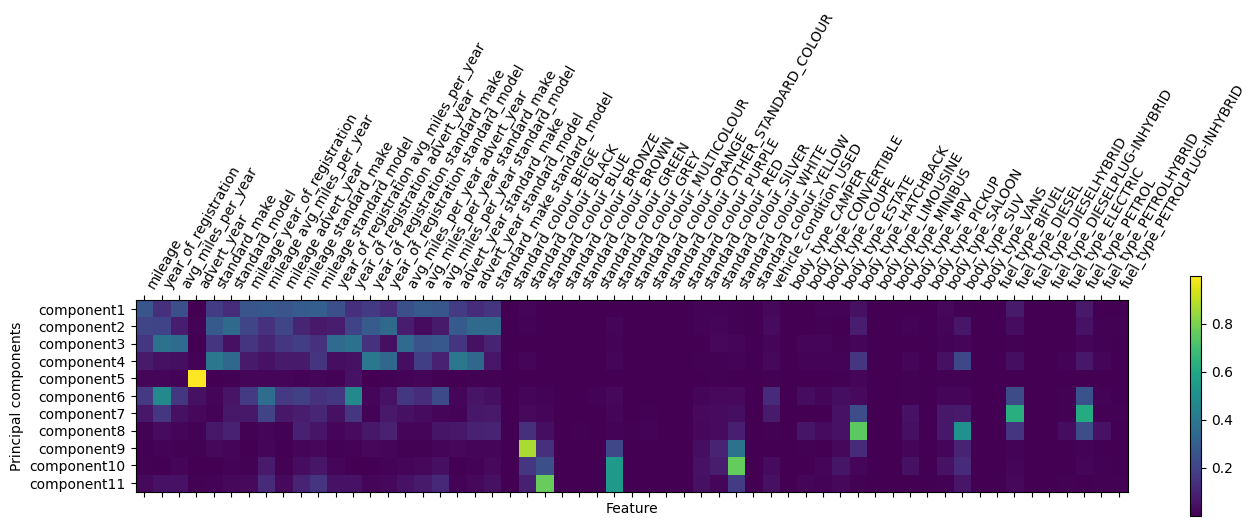

In [95]:
## The Influence of the Features in the Components

plt.matshow(np.abs(X_pca.components_)[:pca_X.shape[1]], cmap='viridis')
plt.yticks(range(pca_X.shape[1]), components)
plt.colorbar()
plt.xticks(range(len(X_train_preprocessed.columns)),
           X_train_preprocessed.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

### Model fitting on PCA components

In [96]:
 def model_selection(xtrain,xtest,ytrain,ytest):
    models = {
        'linear_regression':{
            'model':LinearRegression()
        },
        'random_forest':{
            'model':RandomForestRegressor(random_state=seed)
        },
        'gradient_boost':{
            'model':GradientBoostingRegressor(random_state=seed)
        },
        'histgradient_boost':{
            'model':HistGradientBoostingRegressor(random_state=seed)
        },
       'catboost':{
            'model':CatBoostRegressor(verbose=False,random_state=seed)
        },
        'ridge':{
            'model': Ridge()
        }
    }

    scores = []
    for model_name, config in models.items():
        start = time.time()
        config['model'].fit(xtrain, ytrain)
        y_pred = config['model'].predict(xtest) 
        train_score = config['model'].score(xtrain, ytrain)
        rmse_ = rmse(ytest, y_pred)
        r2score = r2_score(ytest, y_pred)
        end = time.time()
        elasped_time = end - start
        scores.append({
            'model': model_name,
            'train_score':train_score,
            'RMSE':rmse_,
            'r2_score':r2score,
            'time_taken':elasped_time})

    return pd.DataFrame(scores,columns=['model','train_score','RMSE','r2_score','time_taken'])

In [97]:
result_pca= model_selection(pca_X, pca_test, y_train, y_test)

In [98]:
result_pca.sort_values(by='RMSE',ascending=True)

,model,train_score,RMSE,r2_score,time_taken
1,random_forest,0.981672,3122.792897,0.875781,378.919283
4,catboost,0.916602,3151.395020,0.873495,5.182422
3,histgradient_boost,0.893767,3280.824410,0.862891,0.733194
2,gradient_boost,0.840620,3696.426561,0.825954,16.863705
0,linear_regression,0.720192,4683.381038,0.720604,0.032109
5,ridge,0.720192,4683.381777,0.720604,0.018149


Run the entire dataset (`X_train_preprocessed`) on different models

In [99]:
result_whole = model_selection(X_train_preprocessed, X_test_preprocessed, y_train, y_test)

In [100]:
result_whole.sort_values(by='RMSE',ascending=True)

,model,train_score,RMSE,r2_score,time_taken
4,catboost,0.942402,2466.041198,0.922536,5.085767
1,random_forest,0.986473,2658.374406,0.909981,65.321360
3,histgradient_boost,0.925213,2688.102315,0.907957,1.495030
2,gradient_boost,0.876392,3277.589884,0.863161,14.397607
0,linear_regression,0.801538,3973.118896,0.798922,0.202963
5,ridge,0.789732,4079.442560,0.788016,0.025555


### Automated Feature Selection Using Recursive Feature Elimination with Cross-Validation (RFECV)

In [101]:
model = Ridge()
ref_selector = RFECV(model, step=1, cv=10)

In [102]:
ref_selector.fit(X_train_preprocessed, y_train)

RFECV(cv=10, estimator=Ridge())

In [103]:
n_scores = len(ref_selector.cv_results_["mean_test_score"])
n_scores

57

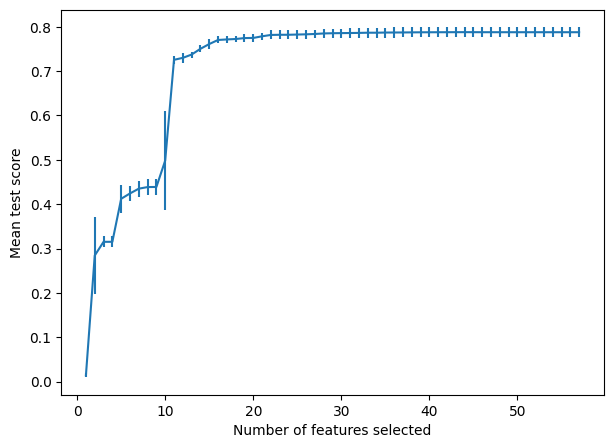

In [104]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector.cv_results_["mean_test_score"],
    yerr=ref_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [105]:
pd.DataFrame(ref_selector.cv_results_["mean_test_score"],range(1, n_scores+1)).sort_values(by=0,ascending=False).head()

,0
44,0.787832
43,0.787803
45,0.787789
46,0.787728
42,0.787722


From the errorbar, after the first 20-30 features, there's no more improvement on the model

In [106]:
# Get the indices of the top performing features
top_features_idx = ref_selector.get_support(indices=True)

# Get the names of the top performing features
top_features_names = X_train_preprocessed.columns[top_features_idx]

# Print the top performing features
print("Top performing features:")
print(len(top_features_names))


Top performing features:
44


In [107]:
assert [i for i in top_features_names] == [i for i in ref_selector.get_feature_names_out()]

### Model fitting and prediction on top selected features by REFCV

In [108]:
result_refcv_full = model_selection(X_train_preprocessed[top_features_names], X_test_preprocessed[top_features_names], y_train, y_test)

In [109]:
result_refcv_full .sort_values(by="RMSE", ascending=True)

,model,train_score,RMSE,r2_score,time_taken
4,catboost,0.942482,2467.869402,0.922421,5.048692
1,random_forest,0.986344,2655.720849,0.910161,47.840510
3,histgradient_boost,0.925695,2678.260166,0.908629,1.368620
2,gradient_boost,0.876297,3279.235608,0.863023,12.085301
0,linear_regression,0.800567,3988.251283,0.797388,0.110034
5,ridge,0.789625,4079.985944,0.787960,0.021984


### Model fitting on top 44 selected features using SelectKbest

In [110]:
selector = SelectKBest(f_regression, k=44).fit(X_train_preprocessed, y_train)
X_sel = selector.transform(X_train_preprocessed)
auto_select = pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).columns

In [111]:
auto_select = auto_select.tolist()

In [112]:
result_selectkbest = model_selection(X_train_preprocessed[auto_select], X_test_preprocessed[auto_select], y_train, y_test)

### Comparing metrics between whole dataset, pca components, slekectKbest and REFCV features

In [113]:
result_pca.sort_values(by='RMSE',ascending=True)

,model,train_score,RMSE,r2_score,time_taken
1,random_forest,0.981672,3122.792897,0.875781,378.919283
4,catboost,0.916602,3151.395020,0.873495,5.182422
3,histgradient_boost,0.893767,3280.824410,0.862891,0.733194
2,gradient_boost,0.840620,3696.426561,0.825954,16.863705
0,linear_regression,0.720192,4683.381038,0.720604,0.032109
5,ridge,0.720192,4683.381777,0.720604,0.018149


In [114]:
result_selectkbest.sort_values(by='RMSE',ascending=True)

,model,train_score,RMSE,r2_score,time_taken
4,catboost,0.942906,2444.389268,0.923890,8.249081
1,random_forest,0.986335,2660.952518,0.909807,55.811929
3,histgradient_boost,0.925078,2684.951880,0.908172,1.303410
2,gradient_boost,0.876176,3268.185460,0.863945,14.474182
0,linear_regression,0.800805,3978.411474,0.798386,0.184509
5,ridge,0.788782,4085.473442,0.787389,0.018641


In [115]:
result_whole.sort_values(by='RMSE',ascending=True)

,model,train_score,RMSE,r2_score,time_taken
4,catboost,0.942402,2466.041198,0.922536,5.085767
1,random_forest,0.986473,2658.374406,0.909981,65.321360
3,histgradient_boost,0.925213,2688.102315,0.907957,1.495030
2,gradient_boost,0.876392,3277.589884,0.863161,14.397607
0,linear_regression,0.801538,3973.118896,0.798922,0.202963
5,ridge,0.789732,4079.442560,0.788016,0.025555


In [116]:
result_refcv_full.sort_values(by='RMSE',ascending=True)

,model,train_score,RMSE,r2_score,time_taken
4,catboost,0.942482,2467.869402,0.922421,5.048692
1,random_forest,0.986344,2655.720849,0.910161,47.840510
3,histgradient_boost,0.925695,2678.260166,0.908629,1.368620
2,gradient_boost,0.876297,3279.235608,0.863023,12.085301
0,linear_regression,0.800567,3988.251283,0.797388,0.110034
5,ridge,0.789625,4079.985944,0.787960,0.021984


### Building a Gridsearch model on Linear Regression model, Random Forest Model, and a Gradient Boosting Model(Catbooost) using top features generated by SelectKbest

In [117]:
def model_pipe(est):
    """ """
    pipe = Pipeline(
        steps=[
            ("pp", preprocessor_pipe()),
            ("featsel", SelectKBest(f_regression, k=44)),
            ("regr", est)
        ]
    ).set_output(transform="pandas")

    return pipe

In [228]:
def evaluate(model):
    scores = []
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    train_score = round(model.score(X_train,y_train),3)
    rmse_ = round(rmse(y_test, y_pred),3)
    r2score = round(r2_score(y_test, y_pred),3)
    scores.append({
    'model': model['regr'],
    'train_score':train_score,
    'RMSE':rmse_,
    'r2_score':r2score})

    return pd.DataFrame(scores,columns=['model','train_score','RMSE','r2_score'])

### Linear Regression Model

In [256]:
# Instantiate model
lr = model_pipe(LinearRegression())

In [246]:
# Define the parameter grid
param_grid = {
    'regr__fit_intercept': [True, False],
    'regr__copy_X': [True, False],
    'regr__n_jobs': [-1, 1, 2]  # Number of CPU cores to use
}
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
grid_lr = GridSearchCV(lr, param_grid,scoring='neg_root_mean_squared_error',cv=kf, return_train_score=True)
grid_lr.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly_int',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['mileage',
                                                                          'year_of_registration',
                                                                          'avg_miles_per_year',
                                                                          'advert_year',
                                                                          '...
                                                                          'vehicle_condition',
                                                                          'body_type',
                                                                          'fuel_type'])],
                                                          verbose_feature_names_out=False)),
                                       ('featsel',
                                        SelectKBest(k=44,
                                                    score_func=<function f_regression at 0x0000024AB038C310>)),
                                       ('regr', LinearRegression())]),
             param_grid={'regr__copy_X': [True, False],
                         'regr__fit_intercept': [True, False],
                         'regr__n_jobs': [-1, 1, 2]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [247]:
print("Best hyperparameters: ", grid_lr.best_params_)
print("Best score: ", grid_lr.best_score_)

Best hyperparameters:  {'regr__copy_X': True, 'regr__fit_intercept': True, 'regr__n_jobs': -1}
Best score:  -3977.506723454874


In [248]:
pd.DataFrame(grid_lr.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score')

,mean_test_score,mean_train_score,params,rank_test_score
0,-3977.506723,-3951.491179,"{'regr__copy_X': True, 'regr__fit_intercept': ...",1
1,-3977.506723,-3951.491179,"{'regr__copy_X': True, 'regr__fit_intercept': ...",1
2,-3977.506723,-3951.491179,"{'regr__copy_X': True, 'regr__fit_intercept': ...",1
6,-3977.506723,-3951.491179,"{'regr__copy_X': False, 'regr__fit_intercept':...",1
7,-3977.506723,-3951.491179,"{'regr__copy_X': False, 'regr__fit_intercept':...",1
8,-3977.506723,-3951.491179,"{'regr__copy_X': False, 'regr__fit_intercept':...",1
3,-3992.524790,-3966.481520,"{'regr__copy_X': True, 'regr__fit_intercept': ...",7
4,-3992.524790,-3966.481520,"{'regr__copy_X': True, 'regr__fit_intercept': ...",7
5,-3992.524790,-3966.481520,"{'regr__copy_X': True, 'regr__fit_intercept': ...",7
9,-3992.524790,-3966.481520,"{'regr__copy_X': False, 'regr__fit_intercept':...",7


In [257]:
# linear model
lr = model_pipe(LinearRegression(n_jobs=-1))
evaluate(lr)

,model,train_score,RMSE,r2_score
0,LinearRegression(n_jobs=-1),0.801,3978.411,0.798


### Random Forest Regression Model

In [123]:
# # Instantiate model
# rfr = model_pipe(RandomForestRegressor())

In [124]:
# # Define the parameter grid
# param_grid = {
#     'regr__n_estimators':[100,150,200],
#     'regr__min_samples_leaf':[1,3,5],
#     'regr__min_samples_split':[2,4,6]
# }
# kf = KFold(n_splits=5, random_state=seed, shuffle=True)
# grid_rfr = GridSearchCV(rfr, param_grid,scoring='neg_root_mean_squared_error',cv=kf, return_train_score=True)
# grid_rfr.fit(X_train,y_train)

In [125]:
# print("Best hyperparameters: ", grid_rfr.best_params_)
# print("Best score: ", grid_rfr.best_score_)

In [126]:
# pd.DataFrame(grid_rfr.cv_results_,columns=['mean_test_score','mean_train_score','params',\
#                                                   'rank_test_score']).sort_values(by='rank_test_score').iloc[14].params

In [251]:
# Random forest model
rfr = model_pipe(RandomForestRegressor(n_estimators=150, min_samples_leaf=3, min_samples_split=2))
evaluate(rfr)

,model,train_score,RMSE,r2_score
0,"(DecisionTreeRegressor(max_features=1.0, min_s...",0.966,2678.537,0.909


### Catboost Regressor Model

In [128]:
# # Instantiate model
# cat = model_pipe(CatBoostRegressor(verbose=False))

In [129]:
# # Define the parameter grid
# param_grid = {
#     'regr__iterations':[1500,2000],
#     'regr__learning_rate':[0.01,0.1],
#     'regr__depth':[6,7,8],
#     'regr__rsm':[0.88,0.98],
#     'regr__l2_leaf_reg':[2.5,3.5],
#     'regr__od_type':['Iter','IncToDec']
# }
# kf = KFold(n_splits=5, random_state=seed, shuffle=True)
# grid_cat = GridSearchCV(cat, param_grid,scoring='neg_root_mean_squared_error',cv=kf, return_train_score=True)
# grid_cat.fit(X_train,y_train)

In [130]:
# print("Best hyperparameters: ", grid_cat.best_params_)
# print("Best score: ", grid_cat.best_score_)

In [131]:
# pd.DataFrame(grid_cat.cv_results_,columns=['mean_test_score','mean_train_score','params',\
#                                                   'rank_test_score']).sort_values(by='rank_test_score').iloc[39].params

In [252]:
cat = model_pipe(CatBoostRegressor(iterations=2000, depth=8, l2_leaf_reg=2.5, learning_rate=0.1, od_type='IncToDec',rsm=0.98, verbose=False))
evaluate(cat)

,model,train_score,RMSE,r2_score
0,<catboost.core.CatBoostRegressor object at 0x0...,0.975,2344.412,0.93


In [259]:
ensembled = [lr, rfr, cat]

In [260]:
# fit all models
for est in ensembled:
    est.fit(X_train, y_train)

In [261]:
ensemble = VotingRegressor([("cat",cat), ("rfr", rfr), ("lr", lr)])

In [263]:
scores = []
ensemble.fit(X_train,y_train)
y_pred = ensemble.predict(X_test) 
train_score = round(ensemble.score(X_train,y_train),3)
rmse_ = round(rmse(y_test, y_pred),3)
r2score = round(r2_score(y_test, y_pred),3)
scores.append({
'model': 'ensemble',
'train_score':train_score,
'RMSE':rmse_,
'r2_score':r2score})


In [264]:
pd.DataFrame(scores,columns=['model','train_score','RMSE','r2_score'])

,model,train_score,RMSE,r2_score
0,ensemble,0.946,2688.474,0.908


In [265]:
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('cat',
                             Pipeline(steps=[('pp',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('poly_int',
                                                                                                PolynomialFeatures(include_bias=False,
                                                                                                                   interaction_only=True)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['mileage',
                                                                                'year_of_registration',
                                                                                'avg_miles_per_year',
                                                                                'advert_year',
                                                                                'standard_make',
                                                                                'standard_model']),
                                                                              ('cat'...
                                                                                'standard_model']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='infrequent_if_exist',
                                                                                                              sparse_output=False))]),
                                                                               ['standard_colour',
                                                                                'vehicle_condition',
                                                                                'body_type',
                                                                                'fuel_type'])],
                                                                verbose_feature_names_out=False)),
                                             ('featsel',
                                              SelectKBest(k=44,
                                                          score_func=<function f_regression at 0x0000024AB038C310>)),
                                             ('regr',
                                              LinearRegression(n_jobs=-1))]))])

In [266]:
all_regr = ensembled + [ ensemble ]
all_regr

[Pipeline(steps=[('pp',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                                   Pipeline(steps=[('poly_int',
                                                                    PolynomialFeatures(include_bias=False,
                                                                                       interaction_only=True)),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['mileage',
                                                    'year_of_registration',
                                                    'avg_miles_per_year',
                                                    'advert_year',
                                                    'standard_make',
                                          

In [267]:
for est in all_regr:
    kf = KFold(n_splits=5, random_state=seed, shuffle=True)
    scores = cross_val_score(est, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    print(scores.mean()*-1, scores.std())

3977.506723454874 98.72861389304273
2650.345593551277 33.33620627278056
2366.8525504512313 33.95555434322206
2690.19454516395 52.923276204832284


## Model predictions vs actual price 

In [268]:
xt = X_train.head(20)
pred1 = lr.predict(xt)
pred2 = rfr.predict(xt)
pred3 = cat.predict(xt)
pred4 = ensemble.predict(xt)
actual = np.array(y_train.head(20))

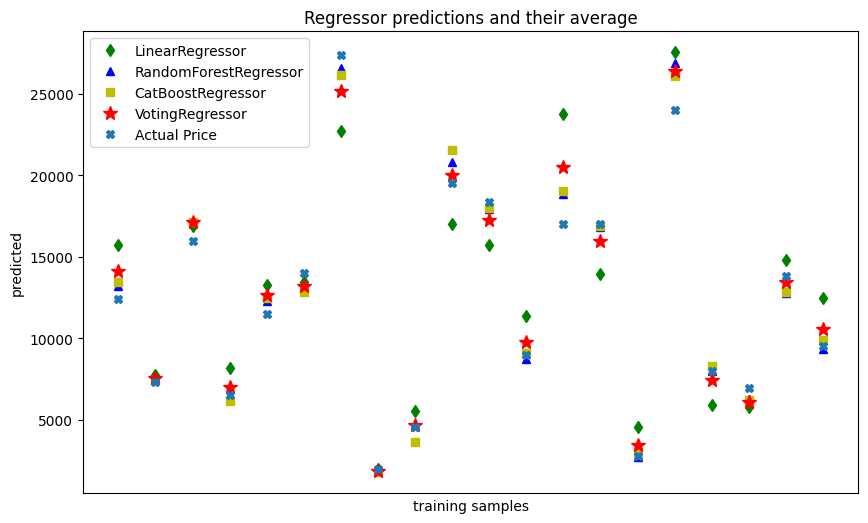

In [269]:
plt.figure(figsize=(10,6))
plt.plot(pred1, "gd", label="LinearRegressor")
plt.plot(pred2, "b^", label="RandomForestRegressor")
plt.plot(pred3, "ys", label="CatBoostRegressor")
plt.plot(pred4, "r*", ms=10, label="VotingRegressor")
plt.plot(actual,"X", label="Actual Price")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

### A voting Regressor excluding the Linear Regression because it RMSE is on a high side comapre to other models 

In [270]:
ensembled2 = [rfr, cat]

In [271]:
for est in ensembled2:
    est.fit(X_train, y_train)

In [272]:
ensemble2 = VotingRegressor([("cat",cat), ("rfr", rfr)])

In [273]:
ensemble2.fit(X_train, y_train)

VotingRegressor(estimators=[('cat',
                             Pipeline(steps=[('pp',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('poly_int',
                                                                                                PolynomialFeatures(include_bias=False,
                                                                                                                   interaction_only=True)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['mileage',
                                                                                'year_of_registration',
                                                                                'avg_miles_per_year',
                                                                                'advert_year',
                                                                                'standard_make',
                                                                                'standard_model']),
                                                                              ('cat'...
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='infrequent_if_exist',
                                                                                                              sparse_output=False))]),
                                                                               ['standard_colour',
                                                                                'vehicle_condition',
                                                                                'body_type',
                                                                                'fuel_type'])],
                                                                verbose_feature_names_out=False)),
                                             ('featsel',
                                              SelectKBest(k=44,
                                                          score_func=<function f_regression at 0x0000024AB038C310>)),
                                             ('regr',
                                              RandomForestRegressor(min_samples_leaf=3,
                                                                    n_estimators=150))]))])

In [274]:
all_regr2 = ensembled2 + [ ensemble2 ]

In [275]:
for est in all_regr2:
    kf = KFold(n_splits=5, random_state=seed, shuffle=True)
    scores = cross_val_score(est, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    print(scores.mean()*-1, scores.std())

2654.3963494378745 37.06811384994039
2366.8525504512313 33.95555434322206
2424.932476065616 33.93776796824489


In [277]:
scores = []
ensemble2.fit(X_train,y_train)
y_pred = ensemble2.predict(X_test) 
train_score = round(ensemble2.score(X_train,y_train),3)
rmse_ = round(rmse(y_test, y_pred),3)
r2score = round(r2_score(y_test, y_pred),3)
scores.append({
'model': 'ensemble',
'train_score':train_score,
'RMSE':rmse_,
'r2_score':r2score})

pd.DataFrame(scores,columns=['model','train_score','RMSE','r2_score'])

,model,train_score,RMSE,r2_score
0,ensemble,0.973,2433.62,0.925



## Model predictions vs actual price 

In [147]:
# from sklearn documentation
xt = X_train.head(20)
pred1 = lr.predict(xt)
pred2 = rfr.predict(xt)
pred3 = cat.predict(xt)
pred4 = ensemble.predict(xt)


In [148]:
actual = np.array(y_train.head(20))

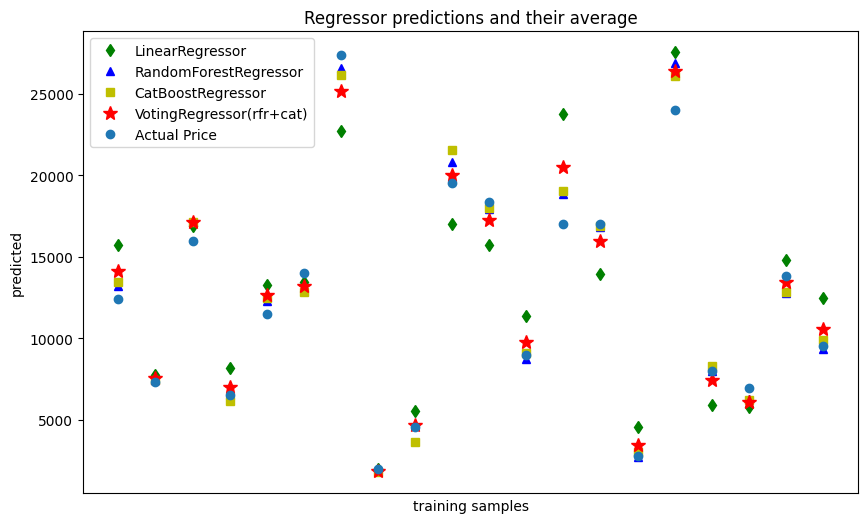

In [294]:
plt.figure(figsize=(10,6))
plt.plot(pred1, "gd", label="LinearRegressor")
plt.plot(pred2, "b^", label="RandomForestRegressor")
plt.plot(pred3, "ys", label="CatBoostRegressor")
plt.plot(pred4, "r*", ms=10, label="VotingRegressor(rfr+cat)")
plt.plot(actual,"o", label="Actual Price")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

In [150]:
actual_predicted = pd.DataFrame(dict(actual=y_test,predicted=cat.predict(X_test)))

In [151]:
actual_predicted.head()

,actual,predicted
public_reference,,
202009213990427,18000,19118.122754
202010225297159,10000,11107.565075
202010074691561,12799,16265.785473
202007231595874,12489,13138.634875
202010165082733,11417,13429.621957


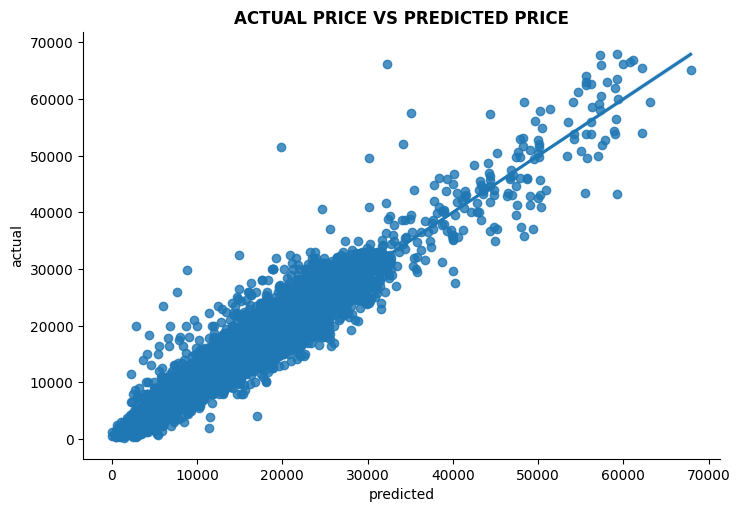

In [152]:
sns.lmplot(x='predicted',y='actual',data=actual_predicted, height=5, aspect=1.5)
plt.title('Actual Price vs Predicted price'.upper(), weight='bold')
plt.savefig('actualvspredicted.png',dpi=300,bbox_inches='tight');

In [153]:
!pip install -q shap
import shap
shap.initjs()
explainer = shap.TreeExplainer(cat['regr'])

In [155]:
shap_values = explainer.shap_values(X_test_preprocessed)

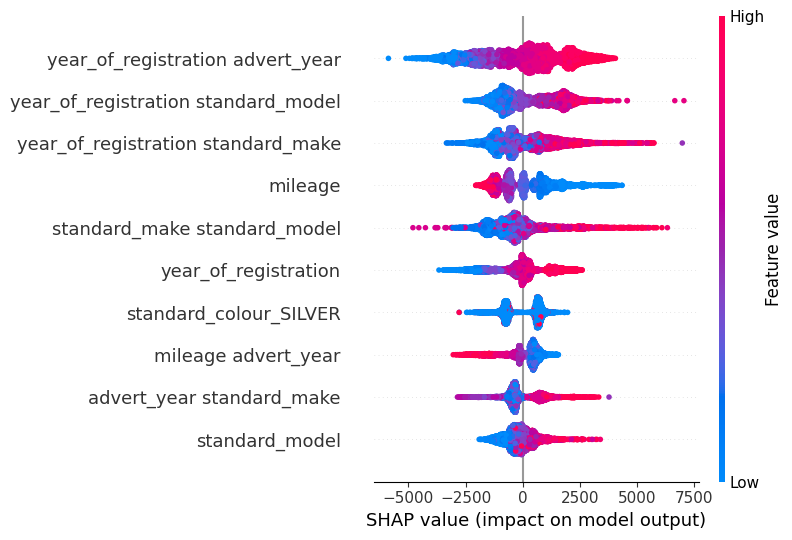

In [278]:
shap.summary_plot(shap_values, X_test_preprocessed, max_display=10)

## I want to use the original category names for the shap values

In [157]:
cols = ['mileage', 'year_of_registration', 'avg_miles_per_year', 'advert_year',
       'standard_make', 'standard_model', 'mileage year_of_registration',
       'mileage avg_miles_per_year', 'mileage advert_year',
       'mileage standard_make', 'mileage standard_model',
       'year_of_registration avg_miles_per_year',
       'year_of_registration advert_year',
       'year_of_registration standard_make',
       'year_of_registration standard_model', 'avg_miles_per_year advert_year',
       'avg_miles_per_year standard_make', 'avg_miles_per_year standard_model',
       'advert_year standard_make', 'advert_year standard_model',
       'standard_make standard_model']

In [158]:
scaler = preprocessor.named_transformers_['num'].named_steps['scaler']
# Inverse transform the scaled numerical features
X_test_preprocessed[cols] = scaler.inverse_transform(X_test_preprocessed[cols])
# Convert the preprocessed data back to a Pandas DataFrame
X_inverse = pd.DataFrame(data=X_test_preprocessed, columns=preprocessor.get_feature_names_out())

In [159]:
# Re splitting the dataset into train and test
# I will get the same splitted data as before because of the seed
seed = 1234
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.25, random_state=seed)
original = pd.concat([X_test_new, y_test_new],axis=1)

In [160]:
X_inverse[['mileage','year_of_registration','avg_miles_per_year','advert_year','standard_make','standard_model']] = original[['mileage','year_of_registration','avg_miles_per_year','advert_year','standard_make','standard_model']]

In [161]:
row_idx = 2000
shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_values[row_idx], 
    X_inverse.iloc[row_idx]
)

In [162]:
X_inverse.iloc[2000]

mileage                                               33974
year_of_registration                                   2018
avg_miles_per_year                                    16987
advert_year                                            2020
standard_make                                 MERCEDES-BENZ
standard_model                                     GLECLASS
mileage year_of_registration                     68559532.0
mileage avg_miles_per_year                      577116338.0
mileage advert_year                              68627480.0
mileage standard_make                      588080397.302941
mileage standard_model                     1177268917.49343
year_of_registration avg_miles_per_year          34279766.0
year_of_registration advert_year                  4076360.0
year_of_registration standard_make          34931013.179412
year_of_registration standard_model          69927847.04485
avg_miles_per_year advert_year                   34313740.0
avg_miles_per_year standard_make        

In [163]:
y_test[202008152518566]

29995

In [164]:
row_idx = 1500
shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_values[row_idx], 
    X_inverse.iloc[row_idx]
)

In [281]:
X_inverse.iloc[1500]

mileage                                               31242
year_of_registration                                   2017
avg_miles_per_year                                    10414
advert_year                                            2020
standard_make                                         SKODA
standard_model                               RAPIDSPACEBACK
mileage year_of_registration                     63015114.0
mileage avg_miles_per_year                      325354188.0
mileage advert_year                              63108840.0
mileage standard_make                      404211318.546763
mileage standard_model                        356108278.675
year_of_registration avg_miles_per_year          21005038.0
year_of_registration advert_year                  4074340.0
year_of_registration standard_make          26096095.944844
year_of_registration standard_model         22990538.316608
avg_miles_per_year advert_year                   21036280.0
avg_miles_per_year standard_make        

In [166]:
y_test[202010165068785]

9750

In [167]:
row_idx = 3000
shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_values[row_idx], 
    X_inverse.iloc[row_idx]
)

In [168]:
X_inverse.iloc[3000]

mileage                                                   0
year_of_registration                                   2020
avg_miles_per_year                                        0
advert_year                                            2020
standard_make                                    VOLKSWAGEN
standard_model                                         POLO
mileage year_of_registration                            0.0
mileage avg_miles_per_year                              0.0
mileage advert_year                                     0.0
mileage standard_make                                   0.0
mileage standard_model                                  0.0
year_of_registration avg_miles_per_year                 0.0
year_of_registration advert_year                  4080400.0
year_of_registration standard_make          27420839.967078
year_of_registration standard_model         20083634.382022
avg_miles_per_year advert_year                          0.0
avg_miles_per_year standard_make        

In [169]:
y_test[202010134937723]

17176

### ICE and PDP

Let us investigate the effect of **year_of_registration advert_year** across the whole range, creating synthetic data from existing instances in the data, according to your ML model.

In [193]:
X_train[['year_of_registration','mileage']].min(), X_train[['year_of_registration','mileage']].max()

(year_of_registration    1963
 mileage                    0
 dtype: int64,
 year_of_registration      2020
 mileage                 200000
 dtype: int64)

In [194]:
year_mileage =  np.linspace(X_train[['year_of_registration','mileage']].min(), X_train[['year_of_registration','mileage']].max(), 100)
year_mileage[:5], year_mileage[-5:]

(array([[1963.        ,    0.        ],
        [1963.57575758, 2020.2020202 ],
        [1964.15151515, 4040.4040404 ],
        [1964.72727273, 6060.60606061],
        [1965.3030303 , 8080.80808081]]),
 array([[  2017.6969697 , 191919.19191919],
        [  2018.27272727, 193939.39393939],
        [  2018.84848485, 195959.5959596 ],
        [  2019.42424242, 197979.7979798 ],
        [  2020.        , 200000.        ]]))

Let us pick an random observation, from which we will produce synthetic ones by varying `temp` across its range.

In [195]:
ex_instance = X_train.sample(1, random_state=42).drop(columns=['year_of_registration','mileage'])
ex_instance

,standard_colour,standard_make,standard_model,vehicle_condition,body_type,fuel_type,advert_year,avg_miles_per_year
public_reference,,,,,,,,
202010265445439,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781


In [196]:
year_mileage_df = pd.DataFrame(year_mileage, columns=['year_of_registration','mileage'])
year_mileage_df.head()

,year_of_registration,mileage
0,1963.000000,0.000000
1,1963.575758,2020.202020
2,1964.151515,4040.404040
3,1964.727273,6060.606061
4,1965.303030,8080.808081


In [197]:
synth_df = ex_instance.merge(year_mileage_df, how='cross')
print(synth_df.shape)
synth_df

(100, 10)


,standard_colour,standard_make,standard_model,vehicle_condition,body_type,fuel_type,advert_year,avg_miles_per_year,year_of_registration,mileage
0,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781,1963.000000,0.000000
1,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781,1963.575758,2020.202020
2,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781,1964.151515,4040.404040
3,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781,1964.727273,6060.606061
4,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781,1965.303030,8080.808081
...,...,...,...,...,...,...,...,...,...,...
95,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781,2017.696970,191919.191919
96,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781,2018.272727,193939.393939
97,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781,2018.848485,195959.595960
98,BLACK,11293.980769,15198.678698,USED,SUV,DIESEL,2020,10781,2019.424242,197979.797980


In [198]:
pred = cat.predict(synth_df)
pred[:5], pred[-5:]

(array([19137.791584  , 19834.41253696, 18690.39414576, 18342.88075083,
        17603.93527715]),
 array([ 9998.81957553, 10362.03004511, 10841.23760422, 10841.23760422,
         9779.62808035]))

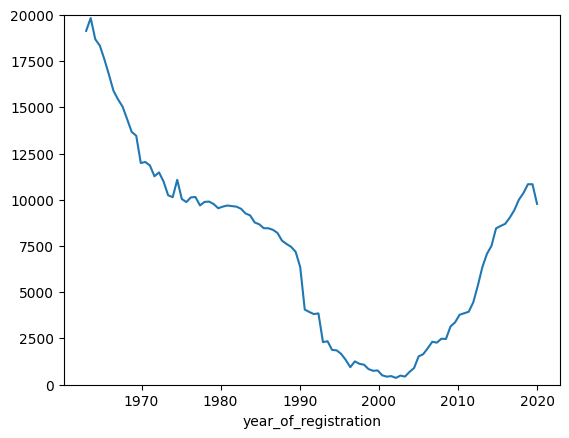

In [207]:
ax = sns.lineplot(x=synth_df['year_of_registration'], y=pred);
ax.set_ylim(0, 20000);

### Partial Dependency Plot (PDP)

* Put simply, for a feature of interest (e.g., `year_of_registration`, `mileage`), a PDP represents the **average of all ICEs**.

In [208]:
from sklearn.inspection import PartialDependenceDisplay

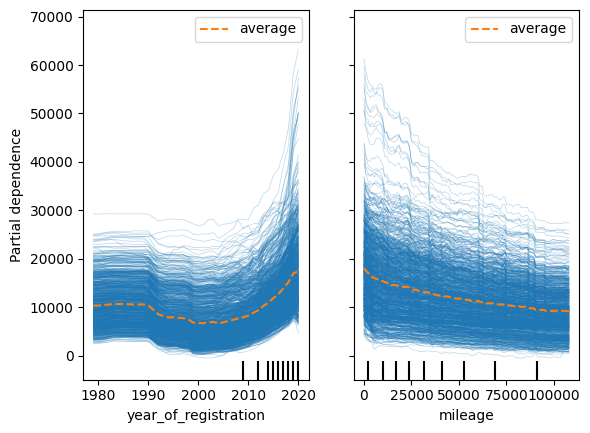

In [289]:
PartialDependenceDisplay.from_estimator(
    cat, X_test, features=['year_of_registration','mileage'], kind='both'
);

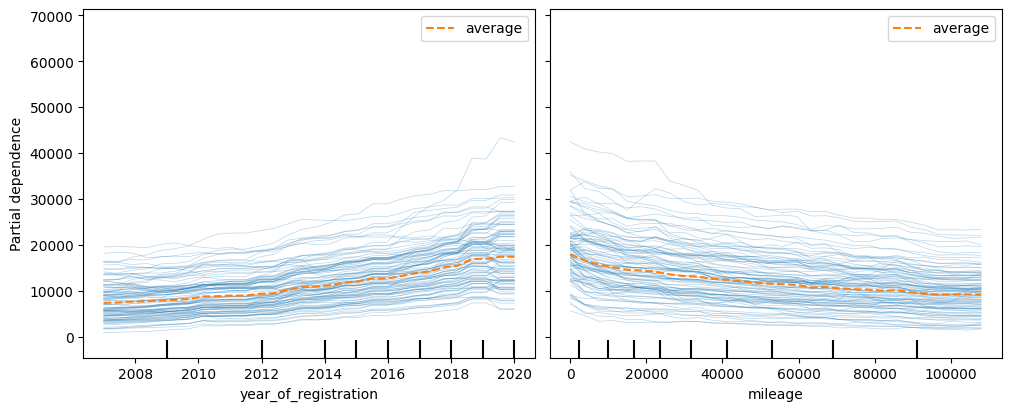

In [293]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    cat, X_test, features=['year_of_registration','mileage'],
    kind='both',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

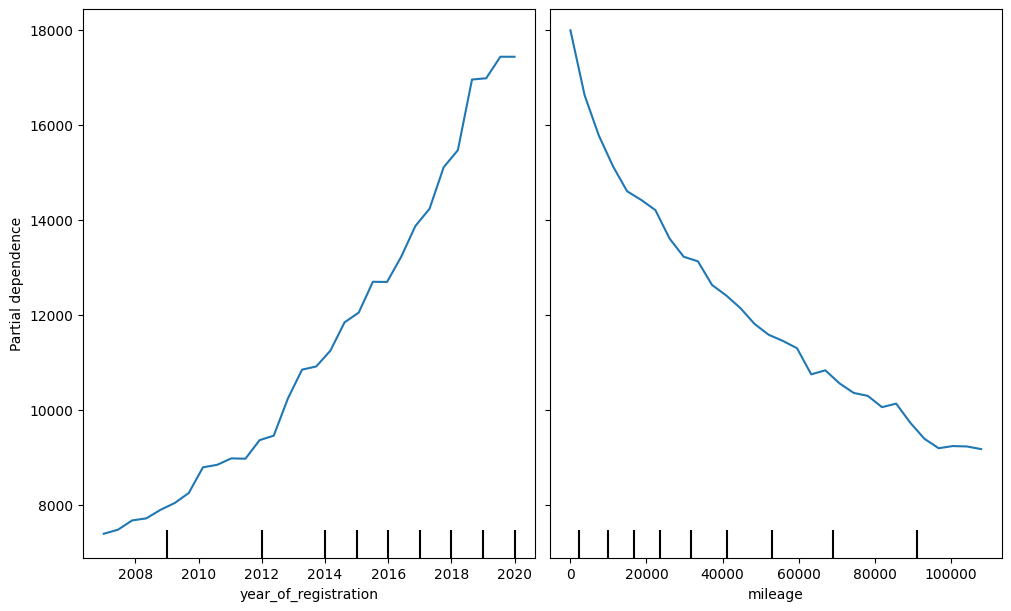

In [291]:
fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    cat, X_test, features=['year_of_registration','mileage'],
    kind='average', 
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

A 2D one gives us the possibility of analysis feature interactions (just the PDP curve; not feasible to show ICEs as well).

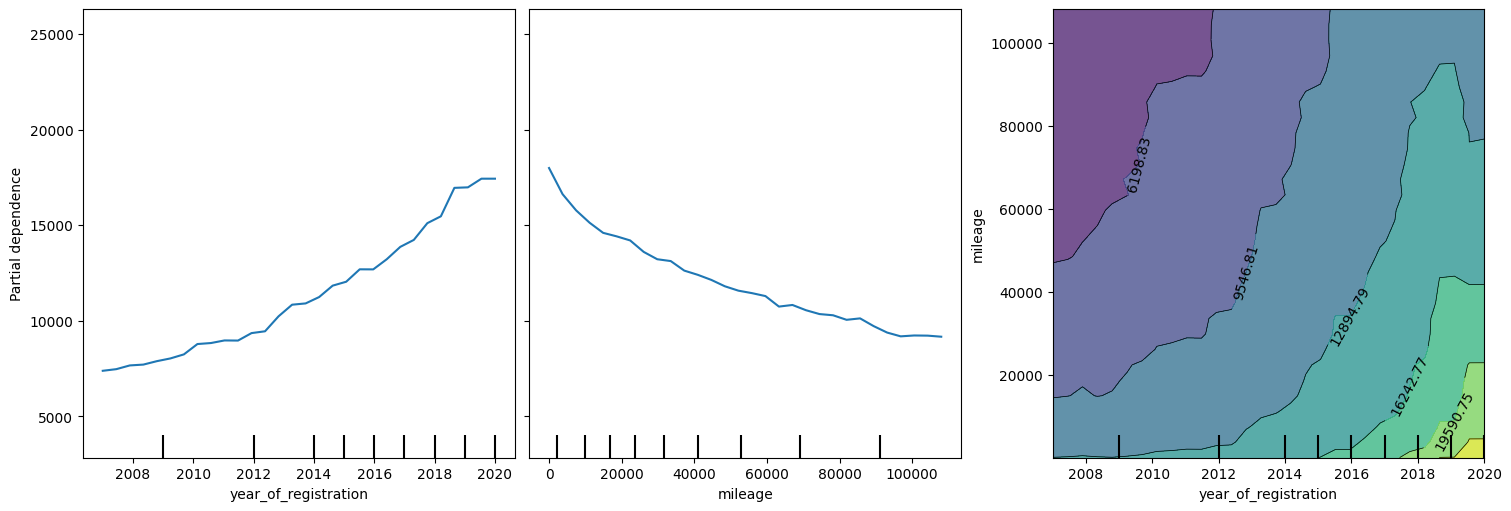

In [292]:
fig, ax = plt.subplots(figsize=(15,5), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    cat, X_test, 
    features=['year_of_registration','mileage', ('year_of_registration','mileage')],
    kind='average', 
    ax=ax, n_cols=3,
    subsample=50, grid_resolution=30, n_jobs=2, random_state=0,
);

# Adebo Dolapo